In [1]:
import csv
import os
import shap
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc, precision_recall_fscore_support
from sklearn import metrics
from tqdm import tqdm

In [2]:
#UTF-8 encoding issue

def pkl_dump(data, file, output_path):
    with open(output_path + file, "wb") as fw:
        pkl.dump(data, fw, pkl.HIGHEST_PROTOCOL)

def pkl_load(file, input_path):
    with open(input_path + file, "rb") as fr:
        data = pkl.load(fr)
    return data

def load_data(features_path,features_filename,data_filename):
    fea2id, features = pkl_load(f"{features_filename}", features_path)
    data = pkl_load(f"{data_filename}", features_path)
    return fea2id,data

def convert_to_dataframe(fea2id,patient_data):
    patient_with_features = pd.DataFrame(columns = ['pid']+list(fea2id.values()))

    for i in range(len(patient_data)):
        patient_with_features.loc[i,'pid']=patient_data[i][0]
        for j in range(1, len(fea2id)+1):
            if j in patient_data[i][1:]:
                patient_with_features.loc[i,j]=1
            else:
                patient_with_features.loc[i,j]=0
    return patient_with_features

In [3]:
input_path = '/mnt/data1/chong/2021-CRC/updated_data/'
data_CC0yr = pd.read_csv(input_path + 'data_CC0yr_expr.csv', dtype=str)

In [4]:
data_CC0yr['outcome'] = data_CC0yr['outcome'].astype('float').astype('int')

In [5]:
data_CC0yr.head()

,pid,outcome,age_40_49,SEX_M,Race_03,Hispanic_N,med_p_26225,med_p_8745,med_p_6628,med_p_9863,...,proc_No charge,diag_24200,diag_7014,diag_25201,proc_9929,proc_0695,med_p_298869,lab_41005-0,diag_255.1,med_p_860807
0,11e75060d2b34f18907a0050569ea8fb,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,11e75060db07ec1ebb6a0050569ea8fb,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11e750610fb3ce06bc3a0050569ea8fb,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,11e75061126eaa76a7850050569ea8fb,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11e75060e4aded54907a0050569ea8fb,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = data_CC0yr.iloc[:,2:]
y = data_CC0yr.iloc[:,1:2]

In [7]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def print_with_ci(performance, name):
    m, m_l, m_h = mean_confidence_interval(performance[name])
    print('%s: %.3f (%.3f, %.3f)'%(name, m, m_l, m_h))
    

In [8]:
from sklearn.metrics import confusion_matrix

def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    #print('True Positives:', TP)
    #print('True Negatives:', TN)
    #print('False Positives:', FP)
    #print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity/recall
    conf_sensitivity_recall = (TP / float(TP + FN))
                                          
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity_recall) / (conf_precision + conf_sensitivity_recall))

    # calculate ppv
    conf_ppv = (TP / float(TP + FP))
                        
    # calculate npv
    conf_npv = (TN / float(TN + FN))
    
    #print('-'*50)
    #print(f'Accuracy: {round(conf_accuracy,2)}') 
    #print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    #print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    #print(f'Specificity: {round(conf_specificity,2)}') 
    #print(f'Precision: {round(conf_precision,2)}')
    #print(f'f_1 Score: {round(conf_f1,2)}')
    return {
        'precision': conf_precision,
        'recall': conf_sensitivity_recall,
        'sensitivity': conf_sensitivity_recall,
        'specificity': conf_specificity,
        'accuracy': conf_accuracy,
        'f1': conf_f1,
        'ppv': conf_ppv,
        'npv': conf_npv
        
    }

In [9]:
def model_with_ci(X, y, clf):
    
    performance = pd.DataFrame()

    metrics_average = 'binary'
    labels = None #[0]
    for i in range(10):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        
        clf.fit(X_train,y_train.values.ravel())
        y_pred=clf.predict(X_test)
        y_prob=clf.predict_proba(X_test)[:,1]

        performance = performance.append({
                'i': i,
                'f1': metrics.f1_score(y_test, y_pred, average=metrics_average, labels = labels),
                'precision': metrics.precision_score(y_test, y_pred, average=metrics_average, labels = labels),
                'recall': metrics.recall_score(y_test, y_pred, average=metrics_average, labels = labels),
                'auc_roc': metrics.roc_auc_score(y_test, y_prob)
            }, ignore_index=True)

    print("--------------------------------------------------")
    print_with_ci(performance, 'f1')
    print_with_ci(performance, 'precision')
    print_with_ci(performance, 'recall')
    print_with_ci(performance, 'auc_roc')

    print("--------------------------------------------------")

In [10]:
model_with_ci(X,y,LogisticRegression(warm_start=True,solver='lbfgs'))

lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.


--------------------------------------------------
f1: 0.556 (0.531, 0.581)
precision: 0.669 (0.636, 0.702)
recall: 0.478 (0.446, 0.510)
auc_roc: 0.843 (0.832, 0.854)
--------------------------------------------------


# Hyperparameter Tunning - 0 YEAR

In [11]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import *

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3282, 8601)
(3282, 1)
(821, 8601)
(821, 1)


In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def model_parameter_tuning(model_type, tuned_parameter, parameter_values):
    train_results = []
    test_results = []

    for value in parameter_values:
        
        for i in range(10):
            performance = pd.DataFrame()
            
            metrics_average = 'binary'
            labels = None

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
            
            if model_type == 'lr':
                clf = LogisticRegression(**{tuned_parameter: value},solver='lbfgs')
            elif model_type == 'rf':
                clf = RandomForestClassifier(**{tuned_parameter: value})
            elif model_type == 'svm':
                clf = SVC(**{tuned_parameter: value})
            elif model_type == 'gbdt':
                clf = GradientBoostingClassifier(**{tuned_parameter: value})
                
            clf.fit(X_train,y_train.values.ravel())
            train_pred=clf.predict(X_train)
            test_pred=clf.predict(X_test)

#             train_prob=clf.predict_proba(X_train)[:,1]
#             test_prob=clf.predict_proba(X_test)[:,1]

            performance = performance.append({
                    'i': i,
                    'train_f1': metrics.f1_score(y_train, train_pred, average='weighted', labels=np.unique(train_pred)),
                    'test_f1': metrics.f1_score(y_test, test_pred, average='weighted', labels=np.unique(test_pred))
                }, ignore_index=True)
                        
            train_f1 = performance['train_f1'].mean()
            test_f1 = performance['test_f1'].mean()


#         clf = LogisticRegression(**{tuned_parameter: value})
#         clf.fit(X_train, y_train)
#         train_pred = clf.predict(X_train)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(train_f1)

#         y_pred = clf.predict(X_test)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(test_f1)

    line1, = plt.plot(parameter_values, train_results, 'b', label="Train F1")
    line2, = plt.plot(parameter_values, test_results, 'r', label="Test F1")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("F1 score")
    plt.xlabel(tuned_parameter)
    plt.show()

### LR

#### max_iter

In [15]:
# X_train, y_train, X_test, y_test = pkl_load('expr_data_CC0yr_train_test.pkl', '/mnt/data1/chong/2021-CRC/updated_data/encoding_files/')

lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge

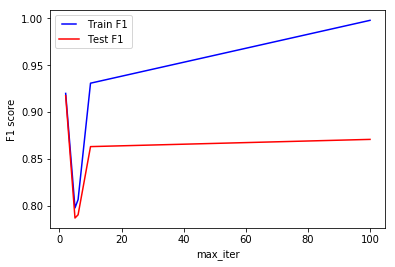

In [16]:
model_parameter_tuning('lr', 'max_iter',[2, 5, 6, 10, 100])
# max_iter: 100

#### tol

lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge

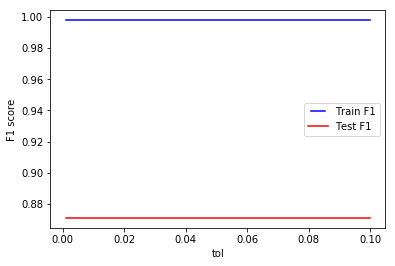

In [17]:
model_parameter_tuning('lr', 'tol',[0.001, 0.01, 0.1])
# tol: 0.10

#### C

lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge

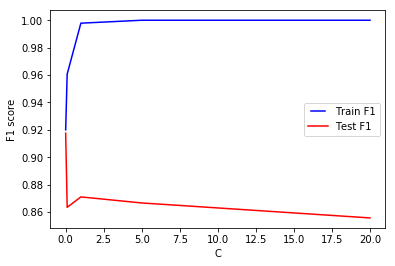

In [18]:
model_parameter_tuning('lr', 'C',[0.001, 0.1, 1, 5, 20])
# C: 1.25

#### solver

In [19]:
# model_parameter_tuning('lr','solver',['sag', 'saga'])

### RF

In [20]:
# how to pass model as a parameter in function
# sklean API docs

# def rf_parameter_tuning(tuned_parameter, parameter_values):
#     train_results = []
#     test_results = []

#     for value in parameter_values:
#         clf = RandomForestClassifier(**{tuned_parameter: value})
#         clf.fit(X_train, y_train)
#         train_pred = clf.predict(X_train)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         train_results.append(roc_auc)

#         y_pred = clf.predict(X_test)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         test_results.append(roc_auc)

#     line1, = plt.plot(parameter_values, train_results, 'b', label="Train AUC")
#     line2, = plt.plot(parameter_values, test_results, 'r', label="Test AUC")
#     plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#     plt.ylabel("AUC score")
#     plt.xlabel(tuned_parameter)
#     plt.show()

#### n_estimators

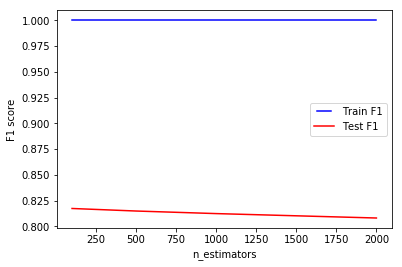

In [21]:
model_parameter_tuning('rf', 'n_estimators',[100, 500, 1000, 2000])
# n_estimators: 100

#### max_depth

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 

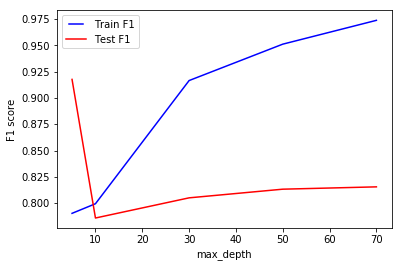

In [22]:
# need to set large range
model_parameter_tuning('rf', 'max_depth',[5, 10, 30, 50, 70])
# max_depth: 70
# defalt value

#### min_samples_leaf

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 

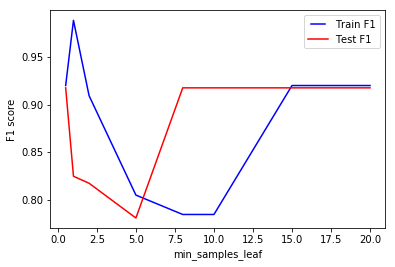

In [23]:
model_parameter_tuning('rf', 'min_samples_leaf',[0.5, 1, 2, 5, 8, 10, 15, 20])
# min_samples_leaf: 20

#### min_weight_fraction_leaf

In [24]:
# model_parameter_tuning('rf', 'min_weight_fraction_leaf',[1e-5, 1e-3])

#### min_samples_split

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 

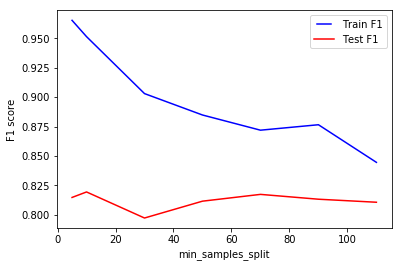

In [25]:
# need to set large range
model_parameter_tuning('rf','min_samples_split',[5, 10,30,50,70,90,110])
# min_samples_split: 8

### SVM

In [26]:
# def svm_parameter_tuning(tuned_parameter, parameter_values):
#     train_results = []
#     test_results = []

#     for value in parameter_values:
#         clf = SVC(**{tuned_parameter: value})
#         clf.fit(X_train, y_train)
#         train_pred = clf.predict(X_train)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         train_results.append(roc_auc)

#         y_pred = clf.predict(X_test)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         test_results.append(roc_auc)

#     line1, = plt.plot(parameter_values, train_results, 'b', label="Train AUC")
#     line2, = plt.plot(parameter_values, test_results, 'r', label="Test AUC")
#     plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#     plt.ylabel("AUC score")
#     plt.xlabel(tuned_parameter)
#     plt.show()

#### C

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to

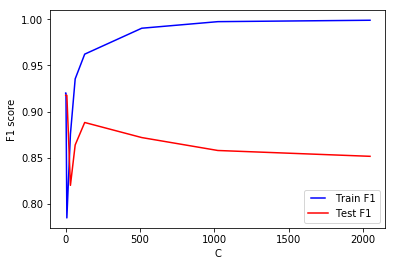

In [28]:
model_parameter_tuning('svm','C',[0.001, 0.01, 0.1, 2, 8, 32, 64, 128, 512, 1024, 2048])
# C: 500

#### gamma

In [29]:
# svm_parameter_tuning('gamma',['scale', 'auto'])

#### kernals

In [30]:
# no need to tune
# svm_parameter_tuning('tol',[0.1, 0.01, 0.001, 0.0001])

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to

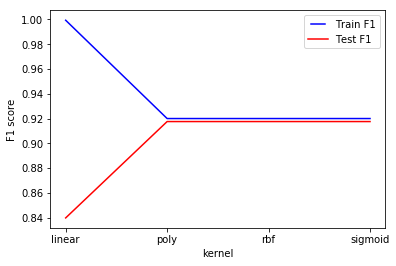

In [31]:
# other kernals SVM
model_parameter_tuning('svm','kernel',['linear', 'poly', 'rbf', 'sigmoid'])
# kernel: poly/rbf/sigmoid

### GBDT

In [32]:
# from sklearn.ensemble import GradientBoostingClassifier

# def gbdt_parameter_tuning(tuned_parameter, parameter_values):
#     train_results = []
#     test_results = []

#     for value in parameter_values:
#         clf = GradientBoostingClassifier(**{tuned_parameter: value})
#         clf.fit(X_train, y_train)
#         train_pred = clf.predict(X_train)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         train_results.append(roc_auc)

#         y_pred = clf.predict(X_test)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         test_results.append(roc_auc)

#     line1, = plt.plot(parameter_values, train_results, 'b', label="Train AUC")
#     line2, = plt.plot(parameter_values, test_results, 'r', label="Test AUC")
#     plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#     plt.ylabel("AUC score")
#     plt.xlabel(tuned_parameter)
#     plt.show()

#### Learning rate

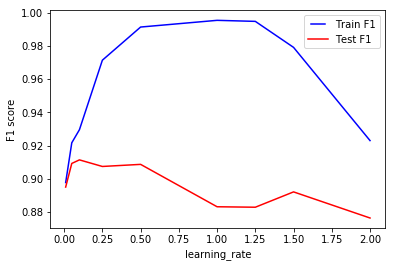

In [33]:
model_parameter_tuning('gbdt','learning_rate',[2.0, 1.50, 1.25, 1, 0.5, 0.25, 0.1, 0.05, 0.01])
# learning_rate: 0.25

#### n_estimators

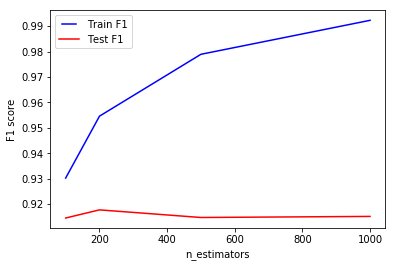

In [34]:
# need to set large range
model_parameter_tuning('gbdt','n_estimators',[100, 200, 500, 1000])
# n_estimators: 500

#### min_samples_split

In [35]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

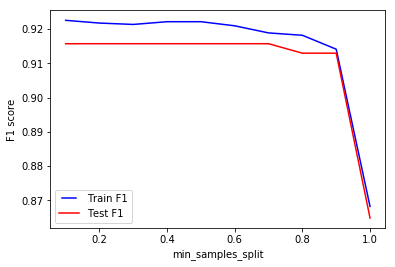

In [36]:
model_parameter_tuning('gbdt','min_samples_split',min_samples_splits)
# min_samples_split: 0.6

#### max features

In [37]:
# no need to tune
max_features = list(range(1,X_train.shape[1]))

In [ ]:
# model_parameter_tuning('gbdt','max_features',max_features)